In [ ]:
import nltk
import re
import random
from nltk.corpus import stopwords, gutenberg
from random import randint
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from six.moves import urllib
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from nltk.stem.wordnet import WordNetLemmatizer
from scipy.stats import randint as sp_randInt
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import uniform as sp_randFloat
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
import os
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument 
import warnings

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!wget 'https://nlp.stanford.edu/software/stanford-ner-2018-10-16.zip'
!unzip stanford-ner-2018-10-16.zip

--2021-10-03 07:35:14--  https://nlp.stanford.edu/software/stanford-ner-2018-10-16.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://downloads.cs.stanford.edu/nlp/software/stanford-ner-2018-10-16.zip [following]
--2021-10-03 07:35:14--  https://downloads.cs.stanford.edu/nlp/software/stanford-ner-2018-10-16.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180358328 (172M) [application/zip]
Saving to: ‘stanford-ner-2018-10-16.zip’

stanford-ner-2018-1 100%[===================>] 172.00M  5.10MB/s    in 30s     

2021-10-03 07:35:45 (5.65 MB/s) - ‘stanford-ner-2018-10-16.zip’ saved [180358328/180358328]

Archive:  stanford-ner-2018-10-16.

In [ ]:
from nltk.tag import StanfordNERTagger
from collections import Counter
import string

def extractText(book):
    '''
    Performs cleaning on the text. Most
    books start and end with a  certain
    pattern, so the  text in the middle
    is extracted.
    '''
    text_start_pattern = re.compile("\*\*\*\s*start.*?\*\*\*", re.IGNORECASE)
    text_end_pattern = re.compile("\*\*\*(\s)*end(.)*\*\*\*", re.IGNORECASE)
    
    start_match = text_start_pattern.search(book)
    end_match = text_end_pattern.search(book)
    
    if(start_match is not None):
        book = book[start_match.end():]
        
    if(end_match is not None):
        book = book[:end_match.start()]
        
    return book

def joinDocPartitions(text_df, EOP_token=None):
    doc_labels = text_df['label'].unique()
    docs = []
    for i, label in enumerate(doc_labels):
        doc_text = text_df[text_df["label"] == label]
        if(EOP_token):
            doc_text = doc_text.apply(lambda x: x + EOP_token)
        text = ' '.join(doc_text["partition"].values)
        docs.append(text)
    return docs


def extractPersonNames(text):
    persons = []
    st = StanfordNERTagger('/content/stanford-ner-2018-10-16/classifiers/english.all.3class.distsim.crf.ser.gz',
                       '/content/stanford-ner-2018-10-16/stanford-ner.jar', encoding='utf-8')
    tokenized_text = nltk.word_tokenize(text)
    tags = st.tag(tokenized_text)
    for tag in tags:
        if tag[1] == 'PERSON':
            persons.append(tag[0].lower())
    return list(set(persons))

def countPunctuation(text):
    punctuation = ['.', '?', '!', ',', ':', ';', '-', 
                   '[', ']', '(', ')', '{', '}', '\'',
                   '\"']
    c = Counter(text)
    count_punct = 0
    for p in punctuation:
        count_punct += c[p]
    return count_punct

def CountPOSTag(df_row):
    words = nltk.word_tokenize(df_row.partition)
    tagged_text = nltk.pos_tag(words, tagset='universal')
    POS_tag_count = dict(Counter(p[1] for p in tagged_text if p[0] not in string.punctuation))
    for key, val in POS_tag_count.items():
        df_row[key] = val
    return df_row

def extractFeatures(df):
    df_features = df.copy()
    df_features["Punct_count"] = df_features["partition"].apply(countPunctuation)
    df_features["Word_count"] = df_features["partition"].apply(lambda x: len([w for w in nltk.word_tokenize(x) 
                                                                         if w not in string.punctuation]))
    df_features['Char_count'] = df_features["partition"].apply(lambda x: sum(len(w) for w in nltk.word_tokenize(x) 
                                                                        if w not in string.punctuation))
    df_features['Avg_word_length'] = df_features['Char_count'] / df_features['Word_count']
    df_features = df_features.apply(CountPOSTag, axis=1)
    df_features.fillna(0, inplace=True)
    
    return df_features

def cleanText(text, remove_words):
    '''Tokenize, stem, and remove
    stopwords along with any other
    required words.
    
    Parameters:
        text(str): Text to be cleaned
    
    Returns:
        text_cleaned(str): Text after cleaning.
    ''' 
    tokenized_words = nltk.word_tokenize(text)

    ps = PorterStemmer()
    stop_words = set(stopwords.words("english") + remove_words)
    
    text_cleaned = [ps.stem(w.lower()) for w in tokenized_words
                    if w.lower() not in stop_words]
    
    text_cleaned = ' '.join(text_cleaned)
    
    # remove special chars
    text_cleaned = re.sub('[^a-zA-Z0-9]', ' ', text_cleaned)
    
    return text_cleaned 

def sampleText(text, n_samples, partition_size, label):
    '''
    Takes random samples from the text. Appending to DataFrames
    is expensive, therefore this returns a list
    of samples that could later be used to create
    a DataFrame.

    Parameters:
        text(str): text to be sampled from.
        n_samples(int): number of samples to be drawn from text.
        sample_len(int): length, in words, of each sample.
        label(str): label to be added to samples from each book.
        
    Returns:
        samples(list): list of tuples containing samples and labels.
    '''
    book_len = len(text.split())
    text_split = text.split()
    partitions = [(' '.join(text_split[i:i+partition_size]), label) 
                  for i in range(0, len(text_split), partition_size)]

    samples = random.sample(partitions, n_samples)
    return samples

def readBook(book_url, encoding='utf-8'):
    '''
    Reads a book from url
    '''
    book = urllib.request.urlopen(book_url).read().decode(encoding)
    return book

In [ ]:
book_urls = [['https://www.gutenberg.org/cache/epub/59072/pg59072.txt', 'a'],
        ['https://www.gutenberg.org/files/434/434-0.txt', 'b'],
        ['https://www.gutenberg.org/cache/epub/59828/pg59828.txt', 'c'],
        ['https://www.gutenberg.org/files/35819/35819-0.txt', 'd'],
        ['https://www.gutenberg.org/files/38743/38743-0.txt', 'e']]

partition_size = 200
n_samples = 200

# Reading books

In [ ]:
'''We read the books, and sample from them before cleaning to avoid losing important features'''
samples = []
person_names_all_books = []

for url, label in book_urls:
    book = readBook(url)
    text = extractText(book)
    sample = sampleText(text, n_samples, partition_size, label)
    samples.extend(sample)
    sampled_text = ' '.join(a[0] for a in sample)
    names = extractPersonNames(sampled_text)
    person_names_all_books.extend(names)

/usr/local/lib/python3.7/dist-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be

In [ ]:
df = pd.DataFrame(samples,columns=['partition','label'])
df

,partition,label
0,"a very low first story, this clock which had e...",a
1,for him to come to a decision which he could n...,a
2,one of its faces and pointed out to Raoul with...,a
3,turns out that there are a hundred and thirty-...,a
4,you suddenly decide to stand by with your arms...,a
...,...,...
995,own such a big body to hold her heart! Ruth to...,e
996,"made straight.” “Oh, Aunt Sarah! I am so glad ...",e
997,"girls. Huh! if I can’t have the dolls I want, ...",e
998,"handbag, and a little later came across Eva. T...",e


In [ ]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'].values)

# Data Exploration

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud

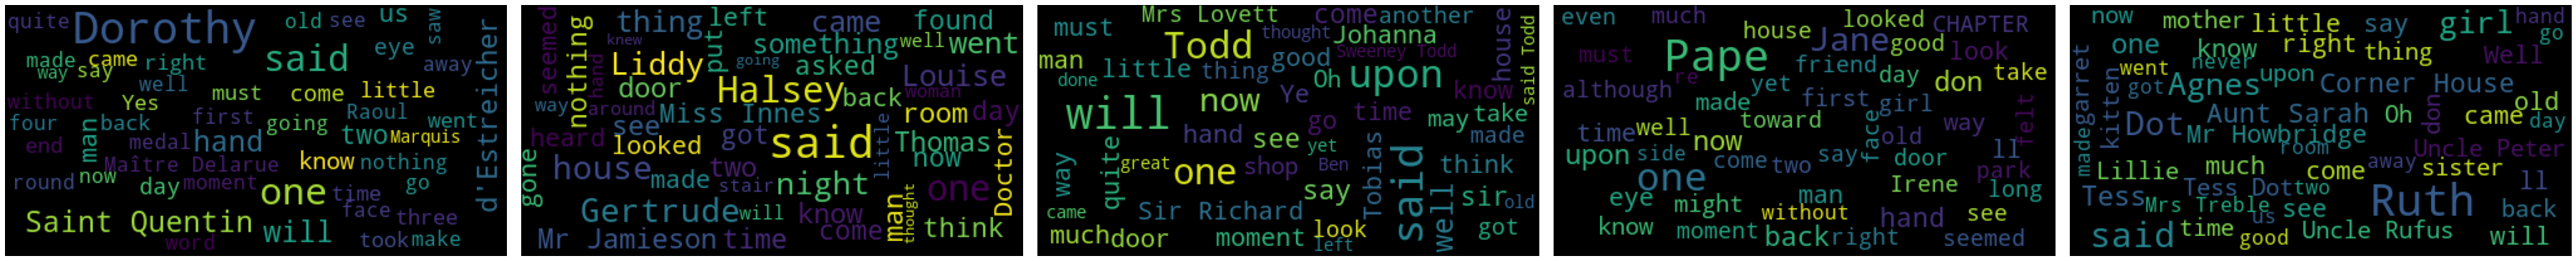

In [ ]:
docs = joinDocPartitions(df)

fig, axs = plt.subplots(1, len(docs), figsize=(50, 5), constrained_layout=True)

for i, doc in enumerate(docs):
  wc = wordcloud.WordCloud(max_words=50, max_font_size=35)

  wc = wc.generate(doc)
  axs[i].axis('off')
  axs[i].imshow(wc, cmap=None)
plt.show()

In [ ]:
df_features = extractFeatures(df)
df_features.head()

,.,ADJ,ADP,ADV,Avg_word_length,CONJ,Char_count,DET,NOUN,NUM,PRON,PRT,Punct_count,VERB,Word_count,X,label,partition
0,0.0,16.0,28,11.0,4.552239,6.0,915,34,62,3.0,9.0,5.0,37,25,201,2.0,0,"a very low first story, this clock which had e..."
1,13.0,5.0,28,16.0,4.143519,4.0,895,24,44,3.0,26.0,8.0,52,43,216,2.0,0,for him to come to a decision which he could n...
2,19.0,9.0,30,12.0,3.986425,7.0,881,23,46,4.0,25.0,8.0,48,37,221,1.0,0,one of its faces and pointed out to Raoul with...
3,23.0,17.0,20,6.0,4.143478,6.0,953,30,48,1.0,23.0,8.0,66,46,230,2.0,0,turns out that there are a hundred and thirty-...
4,25.0,13.0,22,18.0,4.043103,5.0,938,22,37,2.0,32.0,6.0,75,44,232,6.0,0,you suddenly decide to stand by with your arms...


In [ ]:
def plotFeatures(df, feature_cols, target_col, figsize):
    fig, axs = plt.subplots(nrows=len(feature_cols), figsize=figsize)
    for i, col in enumerate(feature_cols):
        sns.kdeplot(x=col, hue=target_col, data=df, ax=axs[i], fill=True, palette='bright')

In [ ]:
POS_feats = ['ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']
sentence_feats = ['Avg_word_length', 'Char_count', 'Punct_count']

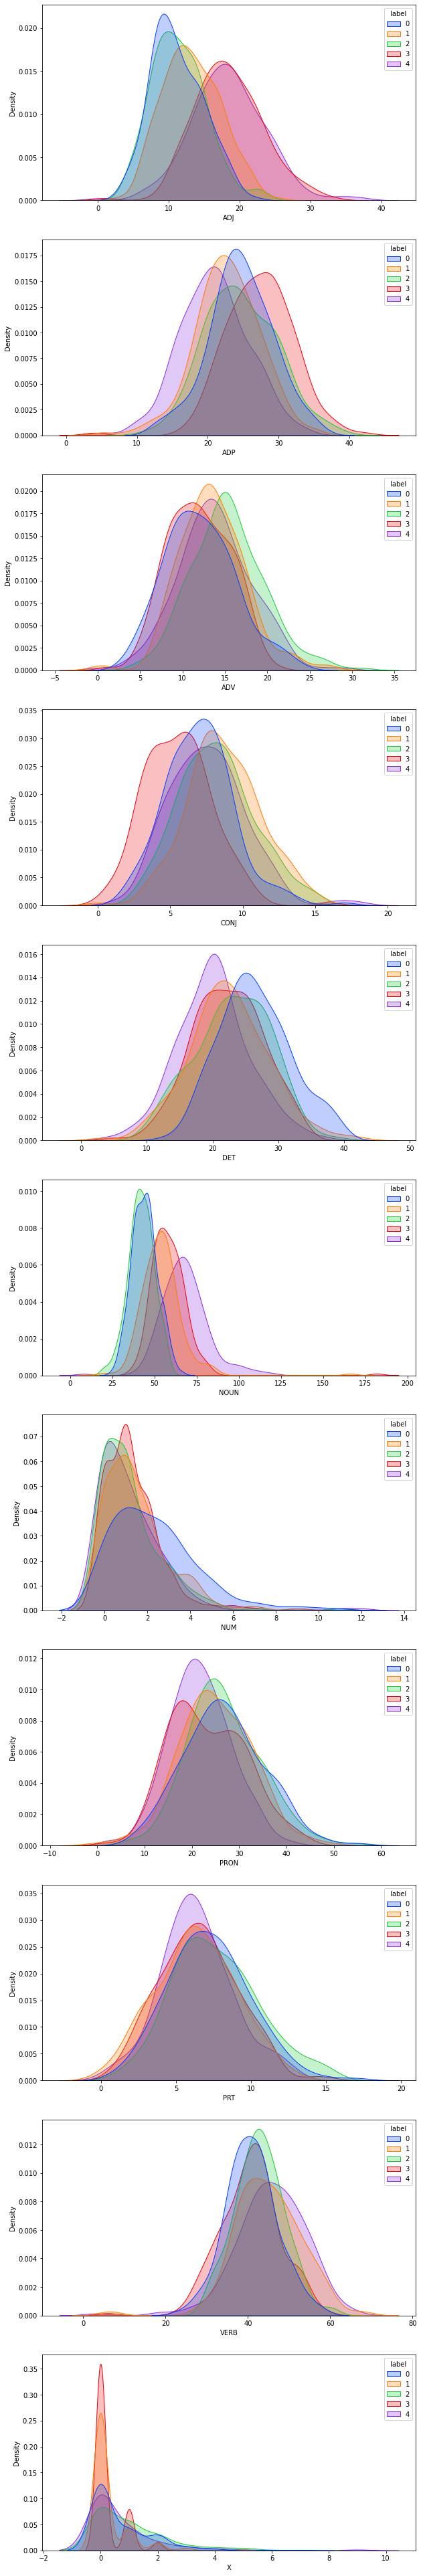

In [ ]:
plotFeatures(df_features, POS_feats, 'label', (10, 70))

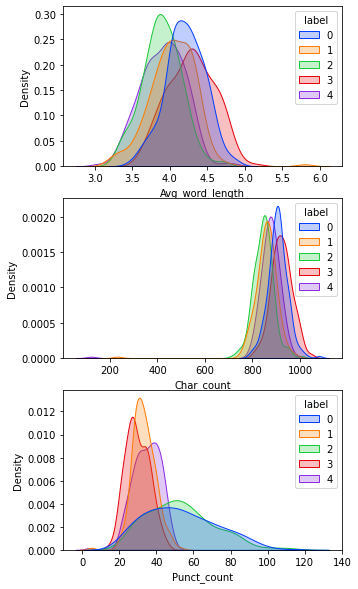

In [ ]:
plotFeatures(df_features, sentence_feats, 'label', figsize=(5, 10))

### Simple random forest
To get a better understanding of the features, we fit a simple random forest model and inspect feature importances.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
mask = np.random.rand(len(df)) < 0.8

In [ ]:
df_features = df_features.sample(frac=1)

df_features_train = df_features[mask]
df_features_test = df_features[~mask]

In [ ]:
df_features_train.head()

,.,ADJ,ADP,ADV,Avg_word_length,CONJ,Char_count,DET,NOUN,NUM,PRON,PRT,Punct_count,VERB,Word_count,X,label,partition
16,6.0,4.0,24,9.0,4.274038,8.0,889,22,38,5.0,38.0,10.0,41,43,208,1.0,0,"of battle. But what has become of the others?""..."
809,0.0,24.0,24,11.0,3.663830,5.0,861,19,81,1.0,21.0,5.0,37,44,235,0.0,4,"the little girls to be asleep. “Why, Aggie,” s..."
507,15.0,15.0,17,20.0,3.760369,9.0,816,25,47,2.0,18.0,4.0,62,44,217,1.0,2,"wouldn't it?"" ""Rather,"" said Todd; ""but he mig..."
124,32.0,11.0,21,16.0,3.690377,8.0,882,16,25,0.0,45.0,5.0,85,58,239,2.0,0,"we threw them into the pool."" ""But you're mad...."
367,1.0,14.0,21,10.0,3.818966,7.0,886,24,59,4.0,30.0,5.0,36,54,232,3.0,1,"step or two that I recognized Gertrude, and sh..."


In [ ]:
X = df_features_train[POS_feats+sentence_feats]
y = df_features_train["label"]

X_test = df_features_test[POS_feats+sentence_feats]
y_test = df_features_test["label"]

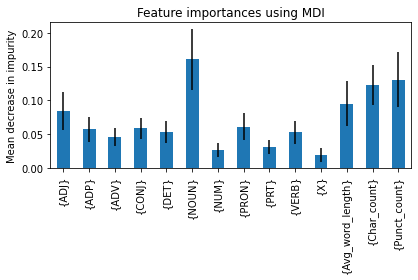

In [ ]:
''' adapted from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html'''

feature_names = [{col} for col in X.columns]
rf = RandomForestClassifier()
rf.fit(X, y)
preds = rf.predict(X_test)

importances = rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig('feature_img.png', dpi=150)

# Clean the Data


In [ ]:
df["partition"] = df["partition"].apply(lambda x: cleanText(x, person_names_all_books))

In [ ]:
df.head()

,partition,label
0,low first stori clock escap miracl man s ra...,0
1,come decis could bring make told servant ill...,0
2,one face point finger deepli engrav word ...,0
3,turn hundr thirty two step shall declar conv...,0
4,suddenli decid stand arm fold singl effort ...,0


In [ ]:
word_count = df["partition"].apply(lambda x: len(x.split()))
word_count

0      105
1       88
2       93
3      104
4       88
      ... 
995     91
996     86
997     83
998     93
999    117
Name: partition, Length: 1000, dtype: int64

# Split the Data

In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
X_train.head()

,partition
382,extend palm see half pearl cuff link quit ...
994,hous next morn slept night paper found old s...
982,cheer place capabl housekeep two year prev...
47,thought get good night s rest return offic qu...
521,come someth eat wo n t go bless thin...


In [ ]:
y_train.head()

382    1
994    4
982    4
47     0
521    2
Name: label, dtype: int64

# BOW

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
'''Helper visualization functions'''

def getMostFreqWordsPerDoc(freq_df, top_n, label):
    label_rows = freq_df[freq_df["label"] == label].iloc[:, :-1]
    sum_row = label_rows.sum()
    freq = sum_row.nlargest(top_n).values
    words = sum_row.nlargest(top_n).index
    
    return words, freq

def getMostFreqWords(freq_df, top_n):
    doc_labels = sorted(freq_df['label'].unique())
    freq_dfs = []
    
    for label in doc_labels:
        words, freq = getMostFreqWordsPerDoc(freq_df, top_n, label)
        
        df = pd.DataFrame(zip(words, freq), columns = ["Term", "Freq"])
        freq_dfs.append(df)

    return freq_dfs

def plotMostFreqWords(freq_dfs, top_n):
    for i, df in enumerate(freq_dfs):
        freq_words = df.iloc[:top_n, :]
        freq_words.plot(x="Term", y="Freq", kind="barh", title=f"Most Freq Terms in Book {i}")
        plt.savefig(f"BOW_res{i}.png", dpi=150, bbox_inches='tight')

In [ ]:
def tuneParams(model, X_train, y_train, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=3) 
    grid_search.fit(X_train, y_train) 
    return grid_search.best_estimator_
    
def fitModelCv(models, X_train, y_train, n_splits=10):
    regex = r'\(.+?\)|".+?"|\w+' 
    kf = KFold(n_splits=n_splits, shuffle=True)
    max_acc = 0
    for i, model in enumerate(models):
        model_name = re.findall(regex, str(model))[0]
        print(f"------------------ {model_name} ------------------")
        scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kf)
        if(mean(scores) > max_acc):
            max_acc = mean(scores)
        print ('kf scores:  %.3f' %(mean(scores)*100) + ' %')
    return max_acc

In [ ]:
def trainVectorizer(vectorizer, X_train, y_train, normalize=False):
    count_data = vectorizer.fit_transform(X_train.partition).toarray()
    vocab = vectorizer.get_feature_names()

    transformed_df = pd.DataFrame(count_data, columns = [v for v in vocab])
    
    if(normalize): 
      transformed_df = transformed_df.div(transformed_df.sum(axis=1) + 1, axis=0)
    transformed_df['label'] = y_train.values
    return transformed_df

In [ ]:
max_features = 200
count_vec = CountVectorizer(max_features=max_features)
bow_df = trainVectorizer(count_vec, X_train, y_train, normalize=True)

In [ ]:
bow_df.head()

,almost,along,although,alway,and,anoth,anyth,appear,arm,around,ask,away,back,bed,began,believ,better,big,black,box,boy,brought,call,came,care,carri,chapter,close,come,could,cours,cri,day,dead,dear,done,door,doubt,end,enough,...,street,sure,take,tell,thing,think,though,thought,three,time,to,told,took,toward,tri,turn,two,upon,us,use,voic,wait,wall,want,watch,way,well,went,window,without,woman,word,work,would,ye,year,yet,you,young,label
0,0.028571,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.028571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.028571,0.0,0.028571,0.0,0.0,0.0,0.0,0.000000,0.028571,0.0,0.000000,0.000000,0.0,0.0,0.028571,0.0,0.00000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.028571,0.028571,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.028571,0.028571,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1
1,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.022222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.022222,0.0,0.0,0.0,0.0,0.000000,0.022222,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,...,0.000000,0.022222,0.0,0.0,0.000000,0.022222,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,4
2,0.028571,0.0,0.0,0.0,0.028571,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.085714,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.028571,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,...,0.028571,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057143,0.028571,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.028571,0.028571,0.0,0.114286,0.0,0.0,0.000000,4
3,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.037037,0.000000,0.0,0.037037,0.074074,0.0,0.0,0.000000,0.0,0.00000,0.111111,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.037037,0.037037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.037037,0
4,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0625,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.031250,0.000000,0.0,0.031250,0.000000,0.0,0.0,0.000000,0.0,0.03125,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.031250,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.031250,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.03125,0.0,0.03125,0.0,0.0,0.0,0.000000,0.062500,0.0,0.000000,0.0,0.0,0.000000,2


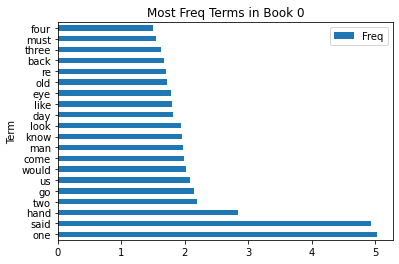

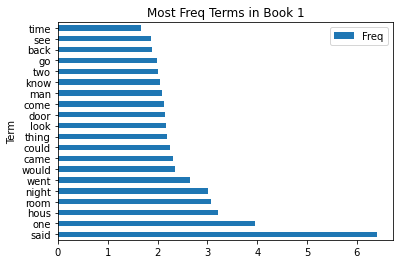

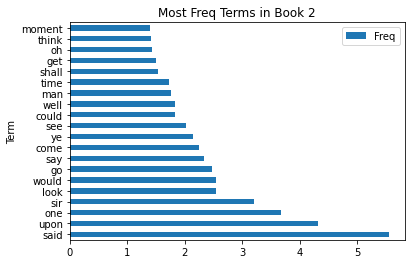

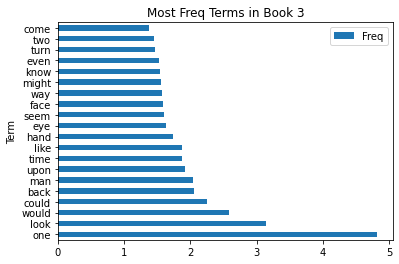

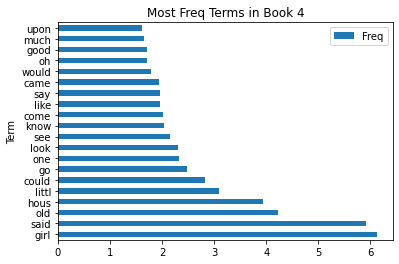

In [ ]:
dfs = getMostFreqWords(bow_df, 200)
plotMostFreqWords(dfs, 20)
plt.savefig("BOW_res.png", dpi=150)

In [ ]:
svc_param_grid = {'C': [0.1, 1, 10, 100, 1000],
                 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                 'kernel': ['linear', 'rbf', 'poly']
                 }

In [ ]:
svc = tuneParams(SVC(), bow_df.iloc[:, :-1], y_train, svc_param_grid)

models = [MultinomialNB(), RandomForestClassifier(n_estimators=100), svc]

In [ ]:
scores = fitModelCv(models, bow_df.iloc[:, :-1], y_train)

------------------ MultinomialNB ------------------
kf scores:  62.875 %
------------------ RandomForestClassifier ------------------
kf scores:  78.625 %
------------------ SVC ------------------
kf scores:  80.250 %


### Inspect the effect of changing BOW max features

In [ ]:
max_features = np.linspace(50, 500, 10)
acc = []

for num in max_features:
    print(f"-------- Features = {num} --------\n")
    count_vec = CountVectorizer(max_features=int(num))
    bow_df = trainVectorizer(count_vec, X_train, y_train)
    curr_acc = fitModelCv(models, bow_df.iloc[:, :-1], y_train)
    acc.append(curr_acc)

-------- Features = 50.0 --------

------------------ MultinomialNB ------------------
kf scores:  58.250 %
------------------ RandomForestClassifier ------------------
kf scores:  65.750 %
------------------ SVC ------------------
kf scores:  64.875 %
-------- Features = 100.0 --------

------------------ MultinomialNB ------------------
kf scores:  64.750 %
------------------ RandomForestClassifier ------------------
kf scores:  73.750 %
------------------ SVC ------------------
kf scores:  73.375 %
-------- Features = 150.0 --------

------------------ MultinomialNB ------------------
kf scores:  62.625 %
------------------ RandomForestClassifier ------------------
kf scores:  73.750 %
------------------ SVC ------------------
kf scores:  76.625 %
-------- Features = 200.0 --------

------------------ MultinomialNB ------------------
kf scores:  63.125 %
------------------ RandomForestClassifier ------------------
kf scores:  77.250 %
------------------ SVC ------------------
kf sco

Text(0.5, 0, 'Vocab Size')

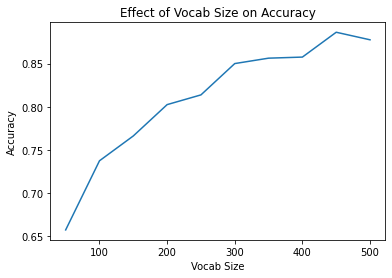

In [ ]:
plt.plot(max_features, acc)
plt.title('Effect of Vocab Size on Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Vocab Size')

### BOW 2-gram 

In [ ]:
max_features = 200
count_vec_ngram = CountVectorizer(ngram_range=(2,2), max_features=max_features)
bow_ngram = trainVectorizer(count_vec_ngram, X_train, y_train, normalize=True)
bow_ngram.head()


,alice dol,ask question,au revoir,beard nobleman,billiard room,board box,call upon,came back,came upon,card board,card room,circular staircas,clear throat,close door,close hand,come along,come back,come come,come said,come see,could get,could hear,could help,could make,could see,cuff link,dead man,dear said,dining room,door close,door open,down stair,drawing room,dri appl,earli morn,east wing,everi day,eye fix,far away,first time,...,think said,to day,to morrow,to night,toss head,trader bank,tri make,trunk room,tulip bed,two girl,two men,two three,up stair,upon hand,us said,utter word,ve got,want go,want know,well said,went back,without know,would better,would go,would like,would made,would said,would say,ye said,ye sir,ye ye,year ago,year old,young girl,young ladi,young man,young men,young woman,younger girl,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.000000,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2


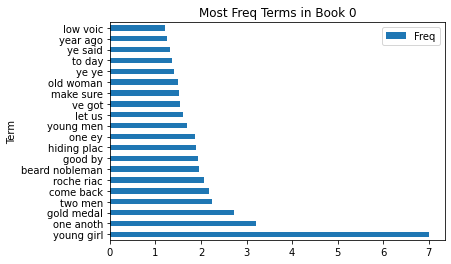

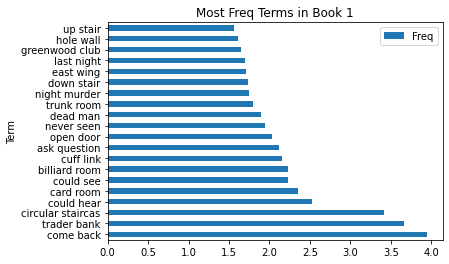

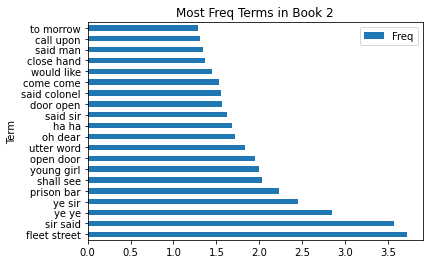

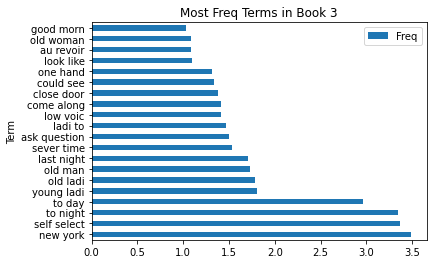

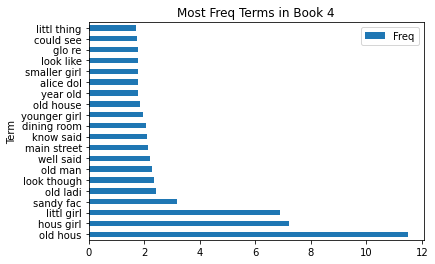

In [ ]:
dfs = getMostFreqWords(bow_ngram, 200)
plotMostFreqWords(dfs, 20)

In [ ]:
scores = fitModelCv(models, bow_ngram.iloc[:, :-1], y_train)

------------------ MultinomialNB ------------------
kf scores:  60.750 %
------------------ RandomForestClassifier ------------------
kf scores:  63.000 %
------------------ SVC ------------------
kf scores:  63.625 %


# TFIDF

In [ ]:
max_features = 200
tfidf_vec = TfidfVectorizer(max_features=max_features)
tfidf_df = trainVectorizer(tfidf_vec, X_train, y_train)
tfidf_df.head()

,almost,along,although,alway,and,anoth,anyth,appear,arm,around,ask,away,back,bed,began,believ,better,big,black,box,boy,brought,call,came,care,carri,chapter,close,come,could,cours,cri,day,dead,dear,done,door,doubt,end,enough,...,street,sure,take,tell,thing,think,though,thought,three,time,to,told,took,toward,tri,turn,two,upon,us,use,voic,wait,wall,want,watch,way,well,went,window,without,woman,word,work,would,ye,year,yet,you,young,label
0,0.182294,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.139120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.186224,0.0,0.123279,0.0,0.0,0.0,0.0,0.000000,0.109538,0.0,0.000000,0.000000,0.0,0.0,0.178635,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.134617,0.138122,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.153269,0.187046,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1
1,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.123596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.109523,0.0,0.0,0.0,0.0,0.000000,0.097315,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.148064,0.0,0.0,0.000000,0.122710,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,4
2,0.143433,0.0,0.0,0.0,0.136324,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.416751,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.108419,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.135825,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.19801,0.102208,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.149865,0.084410,0.0,0.593986,0.0,0.0,0.000000,4
3,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.124442,0.000000,0.0,0.185211,0.302084,0.0,0.0,0.000000,0.0,0.000000,0.561546,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.161212,0.175699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.175153,0
4,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.311006,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.097643,0.000000,0.0,0.145325,0.000000,0.0,0.0,0.000000,0.0,0.163065,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.118797,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.111725,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.111725,0.0,0.147932,0.0,0.0,0.0,0.000000,0.184541,0.0,0.000000,0.0,0.0,0.000000,2


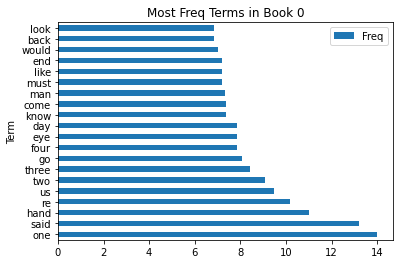

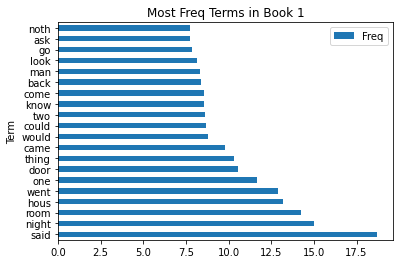

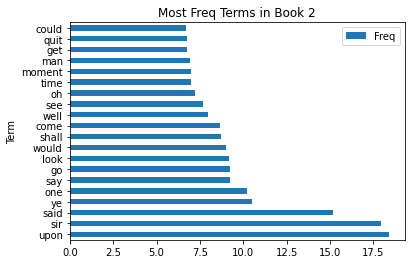

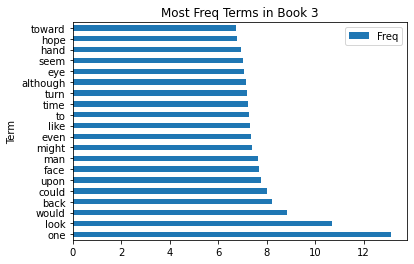

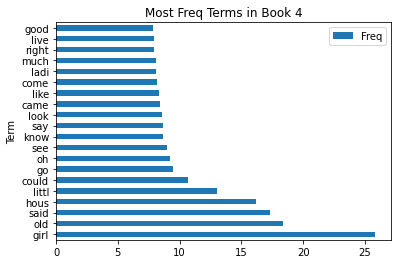

In [ ]:
dfs_tfidf = getMostFreqWords(tfidf_df, 200)
plotMostFreqWords(dfs_tfidf, 20)

In [ ]:
svc = tuneParams(SVC(), tfidf_df.iloc[:, :-1], y_train, svc_param_grid)
models = [MultinomialNB(), RandomForestClassifier(n_estimators=100), svc]

scores = fitModelCv(models, tfidf_df.iloc[:, :-1], y_train)

------------------ MultinomialNB ------------------
kf scores:  59.125 %
------------------ RandomForestClassifier ------------------
kf scores:  78.000 %
------------------ SVC ------------------
kf scores:  82.500 %


### Inspect the effect of changing TFIDF max features

In [ ]:
max_features = np.linspace(50, 500, 10)
acc = []

for num in max_features:
    print(f"-------- Features = {num} --------")
    tfidf_vec = TfidfVectorizer(max_features=int(num))
    tfidf_df = trainVectorizer(tfidf_vec, X_train, y_train)
    curr_acc = fitModelCv(models, tfidf_df.iloc[:, :-1], y_train)
    acc.append(curr_acc)
    

-------- Features = 50.0 --------
------------------ MultinomialNB ------------------
kf scores:  57.000 %
------------------ RandomForestClassifier ------------------
kf scores:  64.875 %
------------------ SVC ------------------
kf scores:  65.875 %
-------- Features = 100.0 --------
------------------ MultinomialNB ------------------
kf scores:  61.625 %
------------------ RandomForestClassifier ------------------
kf scores:  73.625 %
------------------ SVC ------------------
kf scores:  74.125 %
-------- Features = 150.0 --------
------------------ MultinomialNB ------------------
kf scores:  63.125 %
------------------ RandomForestClassifier ------------------
kf scores:  75.500 %
------------------ SVC ------------------
kf scores:  77.125 %
-------- Features = 200.0 --------
------------------ MultinomialNB ------------------
kf scores:  62.875 %
------------------ RandomForestClassifier ------------------
kf scores:  77.750 %
------------------ SVC ------------------
kf scores:

Text(0.5, 0, 'Vocab Size')

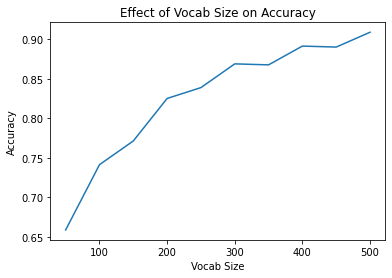

In [ ]:
plt.plot(max_features, acc)
plt.title('Effect of Vocab Size on Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Vocab Size')

### TFIDF ngram

In [ ]:
max_features = 200
tfidf_vec = TfidfVectorizer(ngram_range=(2,2),max_features=max_features)
tfidf_ngram = trainVectorizer(tfidf_vec, X_train, y_train)
tfidf_ngram.head()

,alice dol,ask question,au revoir,beard nobleman,billiard room,board box,call upon,came back,came upon,card board,card room,circular staircas,clear throat,close door,close hand,come along,come back,come come,come said,come see,could get,could hear,could help,could make,could see,cuff link,dead man,dear said,dining room,door close,door open,down stair,drawing room,dri appl,earli morn,east wing,everi day,eye fix,far away,first time,...,think said,to day,to morrow,to night,toss head,trader bank,tri make,trunk room,tulip bed,two girl,two men,two three,up stair,upon hand,us said,utter word,ve got,want go,want know,well said,went back,without know,would better,would go,would like,would made,would said,would say,ye said,ye sir,ye ye,year ago,year old,young girl,young ladi,young man,young men,young woman,younger girl,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.512039,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.464384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.535484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.596135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.33244,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.344093,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2


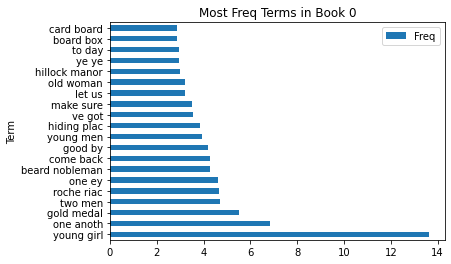

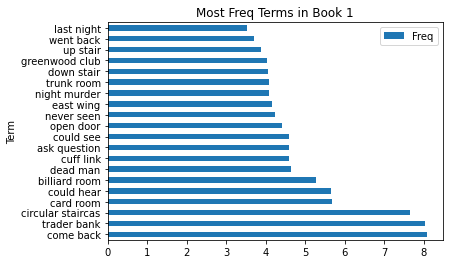

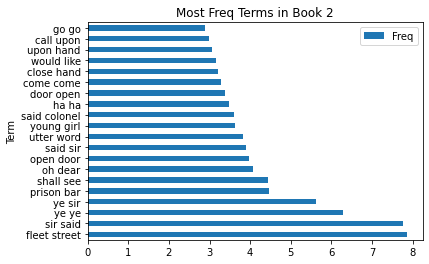

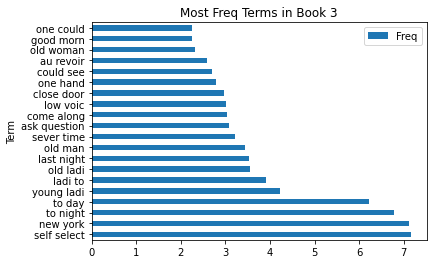

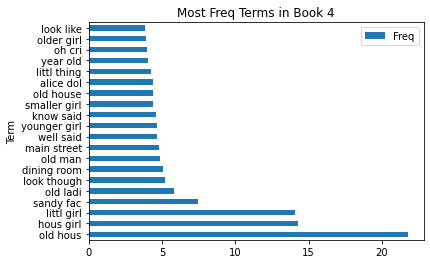

In [ ]:
dfs_tfidf_ngram = getMostFreqWords(tfidf_ngram, 200)
plotMostFreqWords(dfs_tfidf_ngram, 20)

In [ ]:
scores = fitModelCv(models, tfidf_ngram.iloc[:, :-1], y_train)

------------------ MultinomialNB ------------------
kf scores:  60.625 %
------------------ RandomForestClassifier ------------------
kf scores:  66.125 %
------------------ SVC ------------------
kf scores:  64.000 %


# Doc2Vec

In [ ]:
def doc_data(X_train, y_train):
    # To get list of sentences
    doc_train = X_train.values.reshape(X_train.values.shape[0])
    label_train = y_train.values.reshape(y_train.values.shape[0])
    return doc_train, label_train

doc_train, label_train = doc_data(X_train, y_train)

In [ ]:
def Doc2Vec_Model(trainingData , vector_siz , min_word_count , no_epoch ):
    train_data = [TaggedDocument( doc.split(), [i]) for i, doc in enumerate(trainingData)]

    #Train
    model = Doc2Vec(vector_size=vector_siz, min_count=min_word_count, epochs=no_epoch)
    #build vocab
    model.build_vocab(train_data)
    #train
    model.train(train_data, total_examples=model.corpus_count, epochs=model.epochs)

    return model

In [ ]:
"""
input:
  model_ : model trained to get doc2vec
  documents : list of sentences
  labels : list of labels

output : dataframe with doc2vec vector and label
"""
def Doc2Vec_transform(model_,documents,labels):
    docs = [doc.split()for i, doc in enumerate(documents)]

    vectors = [model_.infer_vector(doc) for doc in docs]

    return np.array(vectors) , np.array(labels)

In [ ]:
doc2vecModel = Doc2Vec_Model(doc_train, vector_siz=50, min_word_count = 2, no_epoch = 20)

In [ ]:
svc = tuneParams(SVC(), bow_df.iloc[:, :-1], y_train, svc_param_grid)
models = [RandomForestClassifier(n_estimators=100), svc]

doc2vec_train_x , doc2vec_train_y = Doc2Vec_transform(doc2vecModel, doc_train, label_train)
fitModelCv(models, doc2vec_train_x, doc2vec_train_y)

------------------ RandomForestClassifier ------------------
kf scores:  77.000 %
------------------ SVC ------------------
kf scores:  78.375 %


0.78375

Inspecting the effect of changing vector size on accuracy

In [ ]:
max_features = np.linspace(50, 500, 10)
acc = []

for num in max_features:
    print(f"-------- Features = {num} --------")
    doc2vecModel = Doc2Vec_Model(doc_train, vector_siz=num, min_word_count = 2, no_epoch = 20)
    doc2vec_train_x , doc2vec_train_y = Doc2Vec_transform(doc2vecModel, doc_train, label_train)
    curr_acc = fitModelCv(models, doc2vec_train_x, doc2vec_train_y)
    acc.append(curr_acc)
    

-------- Features = 50.0 --------
------------------ RandomForestClassifier ------------------
kf scores:  77.875 %
------------------ SVC ------------------
kf scores:  79.250 %
-------- Features = 100.0 --------
------------------ RandomForestClassifier ------------------
kf scores:  75.500 %
------------------ SVC ------------------
kf scores:  77.875 %
-------- Features = 150.0 --------
------------------ RandomForestClassifier ------------------
kf scores:  76.625 %
------------------ SVC ------------------
kf scores:  77.125 %
-------- Features = 200.0 --------
------------------ RandomForestClassifier ------------------
kf scores:  76.000 %
------------------ SVC ------------------
kf scores:  77.125 %
-------- Features = 250.0 --------
------------------ RandomForestClassifier ------------------
kf scores:  76.875 %
------------------ SVC ------------------
kf scores:  77.125 %
-------- Features = 300.0 --------
------------------ RandomForestClassifier ------------------
kf sc

Text(0.5, 0, 'Vocab Size')

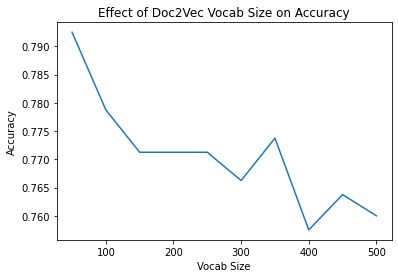

In [ ]:
plt.plot(max_features, acc)
plt.title('Effect of Doc2Vec Vocab Size on Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Vocab Size')

# LDA
reference: https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

In [ ]:
X_train.head()

,partition
382,garden lodg day lodg far enough away hous ...
994,mebb say want tea nuff ter give one fi...
982,repli kind ran behind curtain hung one corne...
47,deepli deplor seem us say ought turn enl...
521,word inconceiv shock discoveri made perfidi fl...


In [ ]:
lda_count_vectorizer = CountVectorizer(min_df=10)
data_vectorized = lda_count_vectorizer.fit_transform(X_train.partition)

In [ ]:
data_dense = data_vectorized.todense()
print("Percentage of nonzero: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Percentage of nonzero:  4.287861915367483 %


In [ ]:
param_grid = {'n_components': [3, 4, 5, 10, 15], 'learning_decay': [.5, .7, .9], 'random_state': [4]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid=param_grid)
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [ ]:
best_lda_model = model.best_estimator_

print("Best Model's Params: ", model.best_params_)

print("Best Log Likelihood Score: ", model.best_score_)

print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 3, 'random_state': 4}
Best Log Likelihood Score:  -78488.31165432752
Model Perplexity:  866.9916235357719


In [ ]:
lda_output = best_lda_model.transform(data_vectorized)
topic_names = [f"Topic {i}" for i in range(best_lda_model.n_components)]

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names)
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic["Label"] = y_train.values

df_document_topic['dominant_topic'] = dominant_topic
df_document_topic.head()

,Topic 0,Topic 1,Topic 2,Label,dominant_topic
0,0.51,0.36,0.12,1,0
1,0.01,0.91,0.08,4,1
2,0.05,0.95,0.01,4,1
3,0.68,0.17,0.15,0,0
4,0.99,0.01,0.01,2,0


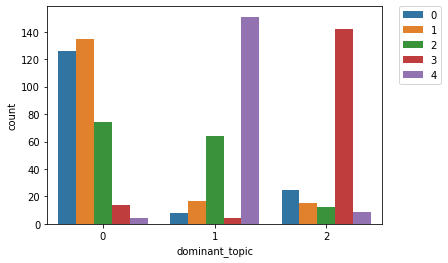

In [ ]:
sns.countplot(x = "dominant_topic",       
            hue = "Label",  # group variable name
            data = df_document_topic)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
X_train_lda, y_train_lda = df_document_topic[["Topic 0", "Topic 1", "Topic 2"]], df_document_topic["Label"]
X_train_lda.head()

,Topic 0,Topic 1,Topic 2
0,0.51,0.36,0.12
1,0.01,0.91,0.08
2,0.05,0.95,0.01
3,0.68,0.17,0.15
4,0.99,0.01,0.01


In [ ]:
svc = tuneParams(SVC(), X_train_lda, y_train_lda, svc_param_grid)
models = [RandomForestClassifier(n_estimators=100), svc]

fitModelCv(models, X_train_lda, y_train_lda)

------------------ RandomForestClassifier ------------------
kf scores:  49.750 %
------------------ SVC ------------------
kf scores:  58.000 %


0.5800000000000001

## Combining tfidf with LDA

In [ ]:
max_features = 300

tfidf_vec = TfidfVectorizer(max_features=max_features)
tfidf_df = trainVectorizer(tfidf_vec, X_train, y_train)

tfidf_lda_df = pd.concat([tfidf_df.iloc[:, :-1], X_train_lda], axis=1)

In [ ]:
tfidf_lda_df.head()

,across,air,almost,alon,along,alreadi,although,alway,among,and,anoth,answer,anyth,appear,arm,around,ask,away,back,bank,bed,began,behind,believ,besid,best,better,black,bodi,box,boy,bring,brought,busi,call,came,car,care,carri,case,...,took,top,toward,town,tri,troubl,turn,two,understand,up,upon,us,use,voic,wait,walk,wall,want,watch,way,well,went,whole,window,wish,within,without,woman,word,work,world,would,ye,year,yet,you,young,Topic 0,Topic 1,Topic 2
0,0.02045,0.02192,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.018996,0.0,0.0,0.0,0.0,0.0,0.000000,0.050154,0.013911,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.018058,0.022629,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.017148,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.019951,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.51,0.36,0.12
1,0.00000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.027305,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.020669,0.0,0.0,0.0,0.0,0.000000,0.042284,0.0,0.0,0.017293,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.014867,0.000000,0.0,0.0,0.0,0.0,0.01,0.91,0.08
2,0.00000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.022317,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.030019,0.000000,0.000000,0.0,0.0,0.0,0.020025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041993,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.019349,0.016430,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.017763,0.000000,0.00000,0.011553,0.015844,0.0,0.0,0.0,0.0,0.05,0.95,0.01
3,0.00000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.034282,0.000000,0.0,0.0,0.0,0.0,0.030816,0.0,0.0,0.0,0.0,0.031827,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.029032,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.091570,0.000000,0.0,0.0,0.0,0.0,0.68,0.17,0.15
4,0.00000,0.00000,0.0,0.096286,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015879,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.030491,0.000000,0.0,0.0,0.044082,0.0,0.0,0.0,0.040301,0.000000,0.02446,0.013106,0.000000,0.0,0.0,0.0,0.0,0.99,0.01,0.01


In [ ]:
svc = tuneParams(SVC(), tfidf_lda_df, y_train_lda, svc_param_grid)
models = [RandomForestClassifier(n_estimators=100), svc]

fitModelCv(models, tfidf_lda_df, y_train_lda)

------------------ RandomForestClassifier ------------------
kf scores:  84.250 %
------------------ SVC ------------------
kf scores:  85.875 %


0.85875

# Choosing Champion Model


In [ ]:
X_test_tfidf_vec = tfidf_vec.transform(X_test.partition).toarray()
vocab = tfidf_vec.get_feature_names()

X_test_tfidf_df = pd.DataFrame(X_test_tfidf_vec, columns = [v for v in vocab])

# normalize df to account for varying length partitions 
tfidf_test = X_test_tfidf_df.div(X_test_tfidf_df.sum(axis=1) + 1, axis=0)

In [ ]:
lda_test_output = best_lda_model.transform(lda_count_vectorizer.transform(X_test.partition))
topic_names = [f"Topic {i}" for i in range(best_lda_model.n_components)]

df_document_topic_test = pd.DataFrame(np.round(lda_test_output, 2), columns=topic_names)
dominant_topic = np.argmax(df_document_topic_test.values, axis=1)
df_document_topic_test["Label"] = y_test.values

df_document_topic_test['dominant_topic'] = dominant_topic
df_document_topic_test.head()

,Topic 0,Topic 1,Topic 2,Label,dominant_topic
0,0.50,0.50,0.01,2,0
1,0.56,0.43,0.01,4,0
2,0.01,0.99,0.01,2,1
3,0.77,0.01,0.22,1,0
4,0.94,0.01,0.05,1,0


In [ ]:
X_test_lda, y_test_lda = df_document_topic_test[["Topic 0", "Topic 1", "Topic 2"]], df_document_topic_test["Label"]
X_test_lda.head()

,Topic 0,Topic 1,Topic 2
0,0.50,0.50,0.01
1,0.56,0.43,0.01
2,0.01,0.99,0.01
3,0.77,0.01,0.22
4,0.94,0.01,0.05


In [ ]:
tfidf_lda_test_df = pd.concat([tfidf_test, X_test_lda], axis=1)
tfidf_lda_test_df.head()

,across,air,almost,alon,along,alreadi,although,alway,among,and,anoth,answer,anyth,appear,arm,around,ask,away,back,bank,bed,began,behind,believ,besid,best,better,black,bodi,box,boy,bring,brought,busi,call,came,car,care,carri,case,...,took,top,toward,town,tri,troubl,turn,two,understand,up,upon,us,use,voic,wait,walk,wall,want,watch,way,well,went,whole,window,wish,within,without,woman,word,work,world,would,ye,year,yet,you,young,Topic 0,Topic 1,Topic 2
0,0.0,0.0,0.000000,0.000000,0.000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.026134,0.00000,0.03298,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.016563,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.017261,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.037331,0.0,0.0,0.0,0.020126,0.50,0.50,0.01
1,0.0,0.0,0.000000,0.024054,0.000,0.0,0.022402,0.020559,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045326,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.00000,0.0,0.021583,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.015729,0.0,0.0,0.000000,0.0,0.041713,0.0,0.0,0.0,0.0,0.018625,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.020632,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.56,0.43,0.01
2,0.0,0.0,0.000000,0.000000,0.000,0.0,0.000000,0.021105,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015511,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.03824,0.00000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.016471,0.015639,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.026890,0.000000,0.0,0.0,0.0,0.000000,0.01,0.99,0.01
3,0.0,0.0,0.000000,0.000000,0.028,0.0,0.000000,0.000000,0.031482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.055999,0.0,0.0,0.0,0.0,0.0,0.026546,0.000000,0.00000,0.00000,0.0,0.000000,0.0,0.000000,...,0.0,0.030585,0.027523,0.0,0.0,0.0,0.0,0.019574,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.032596,0.000000,0.0,0.0,0.0,0.000000,0.77,0.01,0.22
4,0.0,0.0,0.024789,0.000000,0.000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016573,0.0,0.025012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.00000,0.0,0.000000,0.0,0.025854,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.036436,0.0,0.0,0.0,0.026811,0.0,0.000000,0.044174,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.94,0.01,0.05


In [ ]:
svc = tuneParams(SVC(), tfidf_lda_df, y_train_lda, svc_param_grid)
svc

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
preds = svc.predict(tfidf_lda_test_df)
accuracy_score(y_test, preds)

0.875

# Error Analysis

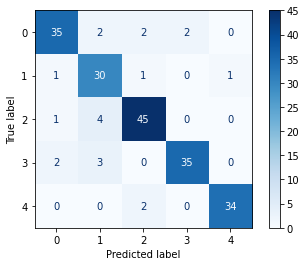

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(svc, tfidf_lda_test_df, y_test, cmap='Blues') 

In [ ]:
wrong_preds = []
wrong_idxs = []
correct_idxs = []

for idx, true, pred in zip(range(len(y_test)) ,y_test, preds):
  if(true != pred):
    wrong_preds.append((true, pred))
    wrong_idxs.append(idx)
  else:
     correct_idxs.append(idx)

counter = dict(Counter(w[0] for w in wrong_preds))
counter = {k: v / len(y_test[y_test == k]) for k, v in counter.items()}

Text(0.5, 1.0, 'Normalized Misclassifications per Class')

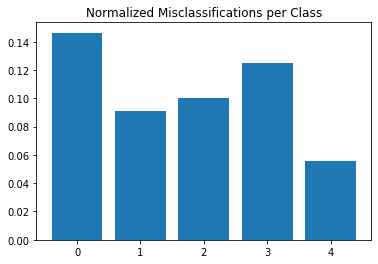

In [ ]:
plt.bar(counter.keys(), counter.values())
plt.title('Normalized Misclassifications per Class')

In [ ]:
def groupMisclassByBook(wrong_preds, n_books):
  all_misclass_idxs = []
  for i in range(n_books):
    misclass = [x for x in range(len(wrong_preds)) if wrong_preds[x][0] == i]
    all_misclass_idxs.append(misclass)
  return all_misclass_idxs

def plotMisclassTopics(misclass, X_test, y_test, colors):
  fig, axes = plt.subplots(nrows=1, ncols=len(misclass), figsize=(30, 5))

  
  for idx, row in enumerate(misclass):
    X_miss = X_test.iloc[row]
    y_miss = y_test.iloc[row]
    
    lda_out = best_lda_model.transform(lda_count_vectorizer.transform(X_miss.partition))
    topic_names = [f"Topic {i}" for i in range(best_lda_model.n_components)]

    test_doc_topic = pd.DataFrame(np.round(lda_out, 2), columns=topic_names)
    dominant_topic = np.argmax(test_doc_topic.values, axis=1)
    test_doc_topic["Label"] = y_miss.values

    test_doc_topic['dominant_topic'] = dominant_topic

    test_doc_topic.dominant_topic.value_counts().plot.bar(title=f"Dominant Topics of Misclassified Examples of Book {idx}",
                                                          xticks=[0,1,2],xlabel="Dominant Topic", ylabel="Frequency", ax=axes[idx],
                                                          color=colors[idx])

In [ ]:
misclass = groupMisclassByBook(wrong_preds, 5)

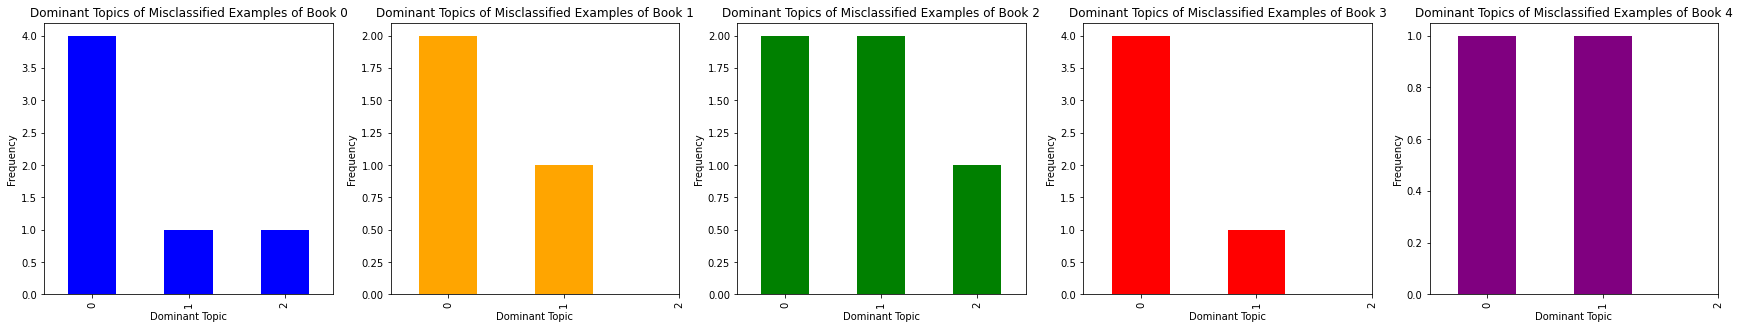

In [ ]:
colors = ['blue', 'orange', 'green', 'red', 'purple']
plotMisclassTopics(misclass, X_test, y_test, colors)